In [1]:
# Import required modules and initialize the builder from open_deep_research
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

0.0.15


In [4]:
# Create a memory-based checkpointer and compile the graph
# This enables state persistence and tracking throughout the workflow execution

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

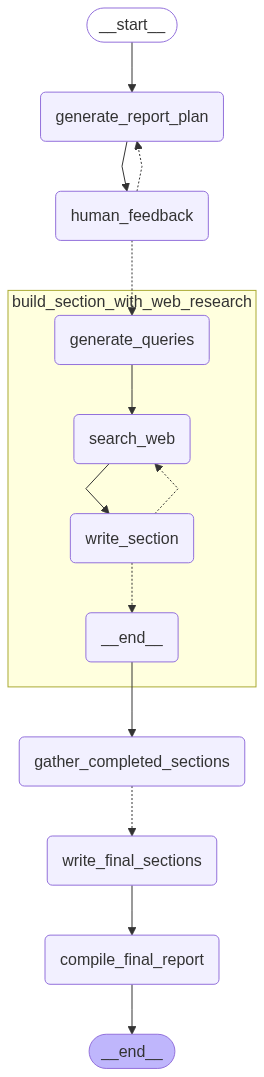

In [5]:
# Visualize the graph structure
# This shows the nodes and edges in the research workflow

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:


os.environ["TAVILY_API_KEY"] = "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"


In [7]:
# Define report structure template and configure the research workflow
# This sets parameters for models, search tools, and report organization

REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""

# Configuration option 1: Claude 3.7 Sonnet for planning with perplexity search
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "anthropic",
                           "planner_model": "claude-3-7-sonnet-latest",
                           # "planner_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "writer_provider": "anthropic",
                           "writer_model": "claude-3-5-sonnet-latest",
                           # "writer_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Configuration option 2: DeepSeek-R1-Distill-Llama-70B for planning and llama-3.3-70b-versatile for writing
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "planner_model": "deepseek-r1-distill-llama-70b",
                           "writer_provider": "groq",
                           "writer_model": "llama-3.3-70b-versatile",
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           }

# Configuration option 3: Use OpenAI o3 for both planning and writing (selected option)
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "planner_model": "gemini-2.5-pro",
                           "writer_provider": "openai",
                           "writer_model": "gemini-2.5-pro",
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           "planner_model_kwargs": {"base_url": "https://vip.apiyi.com/v1",},
                           "writer_model_kwargs": {"base_url": "https://vip.apiyi.com/v1",},}
}
topic = """
I am working on a symbolic regression task.

The dataset describes a biophysical neuron dynamical system, where:
	•	x_1 represents the membrane potential,
	•	x_2 is a fast activation variable (e.g., fast ion channel dynamics),
	•	x_3 is a slow adaptation variable (e.g., slow potassium or calcium currents).

The research goal is to infer the differential equation governing the change in membrane potential, specifically:

y = \frac{dx_1}{dt}

as a function of x_1, x_2, x_3.

It is assumed that the system does not involve magnetic flux modulation.

⸻

Your task is to thoroughly survey and analyze known differential equations from similar biophysical neuron models and provide a prior-informed guide to this task. In particular:
	1.	List and explain the types of functional terms that are typically present in such neuron dynamics equations.
	2.	Based on your research, identify which of the following function types are relevant to include in the symbolic regression search space:
[pow, exp, sqrt, sin, cos, log]
	3.	Finally, write a comprehensive report summarizing your findings, including:
	•	Common equation structures,
	•	Interactions among variables,
	•	Justified recommendations on which functional forms should be enabled or excluded in symbolic modeling of this system.



Your task is to write a report on the user-provided topic.

Read the user’s problem statement and any accompanying data descriptions, perform targeted literature/web searches as needed, and produce a prior-informed technical report with the exact section titles and ordering shown below.

Report Structure
	1.	Variable Introduction
• For each variable x₁, x₂, … (and the target y), state its physical or biological meaning, units (if given), and measurement context.
	2.	Background Equations
• List canonical or widely cited governing equations relevant to the user’s system.
• Provide the full mathematical form and a one-sentence description of each equation’s role.
	3.	Physically Motivated Functional Terms
• Extract from the equations in §2 the most common physically meaningful terms.
• Explain briefly why each term frequently appears in this class of models.
	4.	Recommended Unary Operators
• Based on §§2-3, recommend which unary operators  should be included or excluded in the symbolic-regression search space.
• Justify each recommendation with concrete references or empirical rationale—avoid speculation.
	5.	Summary
• Concisely recap key insights and restate the final list of endorsed unary operators.

Constraints
• The report must be fact-based: cite sources or give canonical references where appropriate.
• Use clear, professional language; avoid jargon unless defined.
• Output only the finished report—do not include search logs or intermediate notes.
"""
# Define research topic about Model Context Protocol
# Run the graph workflow until first interruption (waiting for user feedback)
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    print(event)
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

检测到绑定的工具，正在构建 tool_config 和 tools 请求...
{'queries': [{'search_query': 'biophysical neuron models differential equations membrane potential fast activation slow adaptation'}, {'search_query': 'common functional forms Hodgkin-Huxley FitzHugh-Nagumo Morris-Lecar neuron models dx/dt'}]}
检测到绑定的工具，正在构建 tool_config 和 tools 请求...
{'generate_report_plan': {'sections': [{'content': '', 'description': 'This section introduces the problem of symbolic regression for inferring biophysical neuron dynamics, setting the stage for a prior-informed approach to model discovery.', 'name': 'Introduction', 'research': False}, {'content': '', 'description': 'This section defines the physical and biological meaning of each variable (x₁, x₂, x₃) and the target (y = dx₁/dt), including their typical units and measurement contexts within a biophysical neuron dynamical system.', 'name': 'Variable Introduction', 'research': True}, {'content': '', 'description': 'This section lists and describes canonical or widely c

In [ ]:
from tavily import TavilyClient

# Step 1. Instantiating your TavilyClient
tavily_client = TavilyClient(api_key="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")

# Step 2. Executing a Q&A search query
answer = tavily_client.search(query="antropy库如何计算近似熵",include_raw_content=True, include_source=True, include_summary=True, include_answer=True, include_search_results=True)

# Step 3. That's it! Your question has been answered!
print(answer)

{'query': 'antropy库如何计算近似熵', 'follow_up_questions': None, 'answer': 'The antropy库计算近似熵通过参数m和r，以及数据点数n。m表示嵌入维数，通常取2。近似熵用于分析信号的复杂性。', 'images': [], 'results': [{'url': 'https://blog.csdn.net/weixin_46283583/article/details/124089914', 'title': '近似熵原理(Approximate Entropy)与Python实现原创 - CSDN博客', 'content': '近似熵(Approximate Entropy) · 只要比较短的数据就能得出比较稳健的估计值, 所需数据点数大致是10-5000点, 一般是1000点左右； · 采用短数据估计特征量的', 'score': 0.6551821, 'raw_content': '# 近似熵原理(Approximate Entropy)与Python实现\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/original.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newUpTime2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/articleReadEyes2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollect2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollectionActive2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Black.png)\n![](https://i-blog.c

In [ ]:
from tavily import TavilyClient

# Step 1. Instantiating your TavilyClient
tavily_client = TavilyClient(api_key="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")

# Step 2. Defining the list of URLs to extract content from
urls = [
    "https://blog.csdn.net/weixin_46283583/article/details/124089914"
] # You can provide up to 20 URLs simultaneously

# Step 3. Executing the extract request
response = tavily_client.extract(urls=urls, include_images=False,format="markdown",extract_depth="advanced")

# Step 4. Printing the extracted raw content
for result in response["results"]:
    print(f"URL: {result['url']}")
    print(f"Raw Content: {result['raw_content']}")
    print(f"Images: {result['images']}\n")

# Note that URLs that could not be extracted will be stored in response["failed_results"]

URL: https://blog.csdn.net/weixin_46283583/article/details/124089914
Raw Content: 近似熵原理(Approximate Entropy)与Python实现-CSDN博客


[](https://kunyu.csdn.net/?p=536&spm=3001.5152&a=1070388&c=2529428&k=&d=1&t=3&dest=https%3A%2F%2Ftrae.com.cn%3Futm_source%3Dcommunity%26utm_medium%3Dcsdn%26utm_campaign%3Dbaodeng&timestamp=1750731241529&signature=9f4516f3e913c315a2afe4a4e096d0e50dda32c5)关闭![Image 1](https://kunyu.csdn.net/1.png?p=536&spm=3001.5152&a=1070388&c=2529428&k=&d=1&t=3&u=73a3b9fc6fe84fb3919dcbfbb0dcd040)

[![Image 2: CSDN首页](https://img-home.csdnimg.cn/images/20201124032511.png)](https://www.csdn.net/)

*   [博客](https://blog.csdn.net/)
*   [下载](https://download.csdn.net/)
*   [学习](https://edu.csdn.net/?utm_source=zhuzhantoolbar)
*   [社区](https://devpress.csdn.net/)
*   [![Image 3](https://img-home.csdnimg.cn/images/20240829093757.png)GitCode](https://link.csdn.net/?target=https%3A%2F%2Fgitcode.com%3Futm_source%3Dcsdn_toolbar)
*   [InsCodeAI](https://inscode.csdn.net/?utm_source=2602325

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import entropy

def approximate_entropy(signal, m=2, r=0.2):
    """
    计算时间序列的近似熵(ApEn)
    
    参数:
        signal: 输入时间序列(EEG信号)
        m: 模板长度(通常为2)
        r: 相似度阈值(通常为0.1-0.25倍信号标准差)
    
    返回:
        apen: 近似熵值
    """
    N = len(signal)
    
    # 计算r值(通常为信号标准差的0.2倍)
    r = r * np.std(signal)
    
    def _phi(m):
        """计算phi(m)"""
        # 生成所有可能的m维向量
        x = np.array([signal[i:i+m] for i in range(N - m + 1)])
        
        # 计算向量间的距离
        C = np.zeros(N - m + 1)
        for i in range(N - m + 1):
            # 计算x[i]与其他所有向量的距离
            dist = np.max(np.abs(x - x[i]), axis=1)
            # 统计距离小于r的数量
            C[i] = np.sum(dist <= r) / (N - m + 1)
        
        # 计算phi(m)
        return np.mean(np.log(C))
    
    # 计算ApEn
    apen = _phi(m) - _phi(m + 1)
    return apen

# 示例: 分析EEG信号
if __name__ == "__main__":
    # 生成模拟EEG信号(实际应用中替换为你的EEG数据)
    fs = 250  # 采样频率
    t = np.arange(0, 10, 1/fs)  # 10秒数据
    # 包含不同频率成分的模拟信号
    eeg_signal = (np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t) + 
                 0.2*np.random.randn(len(t)))
    
    # 计算近似熵
    m = 2  # 模板长度
    r = 0.2  # 相似度阈值系数
    apen = approximate_entropy(eeg_signal, m, r)
    
    print(f"近似熵(ApEn)值为: {apen:.4f}")
    
    # 可视化信号
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, eeg_signal)
    plt.title('EEG信号')
    plt.xlabel('时间(s)')
    plt.ylabel('幅度')
    
    # 计算功率谱密度
    freqs, psd = welch(eeg_signal, fs, nperseg=1024)
    plt.subplot(2, 1, 2)
    plt.semilogy(freqs, psd)
    plt.title('功率谱密度')
    plt.xlabel('频率(Hz)')
    plt.ylabel('PSD')
    plt.tight_layout()
    plt.show()

c:\Users\36254\anaconda3\envs\eeg\lib\site-packages\scipy\__init__.py:160: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 2.2.6)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\36254\anaconda3\envs\eeg\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\36254\anaconda3\envs\eeg\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\36254

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
response

{'results': [{'url': 'https://blog.csdn.net/qq_45538220/article/details/130945866',
   'raw_content': '# python计算EEG信号的：近似熵、样本熵、模糊熵\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/original.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newUpTime2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/articleReadEyes2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollect2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollectionActive2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Black.png)\n![](https://img-home.csdnimg.cn/images/20240711042549.png)\n\n摘要生成于\n [C知道](https://ai.csdn.net?utm_source=cknow_pc_ai_abstract)\n，由 DeepSeek-R1 满血版支持，\n [前往体验 >](https://ai.csdn.net?utm_source=cknow_pc_ai_abstract)\n\n### 从原理出发利用python计算EEG信号的近似熵、样本熵和模糊熵。具体的原理我就不在这里说了，网上有很多讲解得很好的，一搜就有很多。我这里就给大家展示一下python的实现过程和结果，代码纯手敲，还没有对比工具箱的计算结果，不过应该可以帮助你更好的理解这几个熵的计算过程。因为我

In [ ]:
answer['results'][0]["url"]
# '# python计算EEG信号的：近似熵、样本熵、模糊熵\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/original.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newUpTime2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/articleReadEyes2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollect2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarCollectionActive2.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newHeart2023Black.png)\n![](https://img-home.csdnimg.cn/images/20240711042549.png)\n\n摘要生成于\n [C知道](https://ai.csdn.net?utm_source=cknow_pc_ai_abstract)\n，由 DeepSeek-R1 满血版支持，\n [前往体验 >](https://ai.csdn.net?utm_source=cknow_pc_ai_abstract)\n\n### 从原理出发利用python计算EEG信号的近似熵、样本熵和模糊熵。具体的原理我就不在这里说了，网上有很多讲解得很好的，一搜就有很多。我这里就给大家展示一下python的实现过程和结果，代码纯手敲，还没有对比工具箱的计算结果，不过应该可以帮助你更好的理解这几个熵的计算过程。因为我看原理公式的时候总是看不明白，通过代码感觉会更清晰。希望对你也是一样。若有错误，欢迎指出。\n\n![在这里插入图片描述](https://i-blog.csdnimg.cn/blog_migrate/e7b1e81965889bfcd8476db5980ae36a.png)\n\n![在这里插入图片描述](https://i-blog.csdnimg.cn/blog_migrate/e7b1e81965889bfcd8476db5980ae36a.png)\n\n### 一、近似熵\n\n`def ApEn(x, m, r): # 2. m：模式维数， r：相似容限\nN = len(x) # 1. 信号总长N\nx = np.array(x)\nif x.ndim != 1:\nraise ValueError("x的维度不是一维")\nif N < m + 1:\nraise ValueError("len(x)小于m+1")\nphi = []\nfor temp in range(2): # 7. 将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1\n# 3. 以m为窗，将时间序列分为k = n-m+1个序列\nX = []\nm = m+temp\nfor i in range(N + 1 - m):\nX.append(x[i:i+m])\nX = np.array(X)\n# 4. 计算每个i与所有j之间的绝对值距离，获取统计个数：N_m(i)【count】\nC = []\nfor index1, i in enumerate(X):\ncount = 0\nfor index2, j in enumerate(X):\nif index1 != index2:\nif np.max(np.abs(i-j)) <= r:\ncount += 1\n# 5. 获取 C\nC.append(count/(N-m+1))\n# 处理C为0的值，替换为一个非零的很小的数,以防取对数时报错\nC = np.array(C)\nC = np.where(C == 0, 1e-10, C)\n# 6. 对每个C取自然对数，获取 Φ\nphi.append(np.sum(np.log(C))/(N-m+1))\n# 8. 获取近似熵\napEn = phi[0] - phi[1]\nreturn apEn`\n\n### 二、样本熵\n\n`def SampEn(x, m, r):\nN = len(x) # 1. 信号总长N\nx = np.array(x)\nif x.ndim != 1:\nraise ValueError("x的维度不是一维")\nif N < m + 1:\nraise ValueError("len(x)小于m+1")\nAB = []\nfor temp in range(2): # 7. 将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1\n# 3. 以m为窗，将时间序列分为k = n-m+1个序列\nX = []\nm = m+temp\nfor i in range(N + 1 - m):\nX.append(x[i:i+m])\nX = np.array(X)\n# 4. 计算每个i与所有j之间的绝对值距离，统计距离d小于r的个数：N_m(i)【count】\nC = []\nfor index1, i in enumerate(X):\ncount = 0\nfor index2, j in enumerate(X):\nif index1 != index2:\nif np.max(np.abs(i-j)) <= r:\ncount += 1\n# 5. 获取每个i的 C\nC.append(count/(N-m+1))\n# 处理C为0的值，替换为一个非零的很小的数,以防取对数时报错\nC = np.array(C)\nC = np.where(C == 0, 1e-10, C)\n# 6. 求所有i得平均值\nAB.append(np.sum(C)/(N-m+1))\n# 8. 获取样本熵\nSE = np.log(AB[0]) - np.log(AB[1])\nreturn SE`\n\n### 三、模糊熵\n\n`def FuzzyEntopy(x, m, r, n=2):\nx = np.array(x)\nif x.ndim != 1:\nraise ValueError("x的维度不是一维")\nif len(x) < m + 1:\nraise ValueError("len(x)小于m+1")\nentropy = 0\nfor temp in range(2): # 5. 将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1\n# 2. 以m为窗，将时间序列分为k = n-m+1个序列\nX = []\nfor i in range(len(x) + 1 - (m + temp)):\nX.append(x[i:i+m+temp])\nX = np.array(X)\nD_value = []\n# 3. 计算绝对距离\nfor index1, i in enumerate(X):\nd = []\nfor index2, j in enumerate(X):\nif index1 != index2:\nd.append(np.max(np.abs(i-j)))\nD_value.append(d)\n# 4. 计算模糊隶属度D\nD = np.exp(-np.power(D_value, n)/r)\nLm = np.average(D.ravel())\n# 6. 计算模糊熵\nentropy = np.abs(entropy) - np.log(Lm)\nreturn entropy`\n\n![在这里插入图片描述](https://i-blog.csdnimg.cn/blog_migrate/bfeed207b8253d1c3217664e77198997.png)\n\n![在这里插入图片描述](https://i-blog.csdnimg.cn/blog_migrate/bfeed207b8253d1c3217664e77198997.png)\n\n### 四、结果\n\n![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/aef30a66e831330ae1b8023436d8a950.jpeg)  \n ![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/4c5ac1b2e27021a47f9d0c4ddd2b8c56.jpeg)  \n ![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/07387fd2c5451fa4fb5258e310ca89f0.jpeg)\n\n![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/aef30a66e831330ae1b8023436d8a950.jpeg)  \n ![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/4c5ac1b2e27021a47f9d0c4ddd2b8c56.jpeg)  \n ![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/07387fd2c5451fa4fb5258e310ca89f0.jpeg)\n![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/4c5ac1b2e27021a47f9d0c4ddd2b8c56.jpeg)  \n ![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/07387fd2c5451fa4fb5258e310ca89f0.jpeg)\n![请添加图片描述](https://i-blog.csdnimg.cn/blog_migrate/07387fd2c5451fa4fb5258e310ca89f0.jpeg)\n\n### 五、完整代码\n\n<https://github.com/weisihong9/ApEn_SaEn_FuEn.git>\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/vip-limited-close-newWhite.png)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/vip-limited-close-roup.png)\n立减 ¥\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/vip-limited-close-roup.png)\n![](https://profile-avatar.csdnimg.cn/a3f2474f318a4e72b7ce223b65be47a1_qq_45538220.jpg!1)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/tobarThumbUpactive.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/like-active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/like.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/unlike-active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/unlike.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/collect-active.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/collect.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/newCollectActive.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/collectionCloseWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/guideRedReward01.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/comment.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/share.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/share/icon-wechat.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/more.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/report.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/toolbar/report.png)\n![]()\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://profile-avatar.csdnimg.cn/a3f2474f318a4e72b7ce223b65be47a1_qq_45538220.jpg!1)\n\n博客等级\n![](https://csdnimg.cn/identity/blog4.png)\n\n![](https://csdnimg.cn/identity/blog4.png)\n![](https://i-operation.csdnimg.cn/images/f70cbe190d3c4f25901cb03b6971f64d.png)\n![](https://i-operation.csdnimg.cn/images/bfc20af708654cc689adbb6361f6dc98.png)\n![]()\n\n### TA的精选\n\n286 阅读\n\n193 阅读\n\n13929 阅读\n\n9179 阅读\n\n8412 阅读\n\n[查看更多 ![](https://csdnimg.cn/release/blogv2/dist/pc/img/commentArrowRightWhite.png)](https://blog.csdn.net/qq_45538220?type=blog)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/commentArrowRightWhite.png)\n\n### 大家在看\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/readCountWhite.png)\n![]()\n\n### 目录\n\n展开全部 ![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-bot-White.png)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-bot-White.png)\n\n收起 ![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-top-White.png)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-top-White.png)\n![]()\n\n### 目录\n\n展开全部 ![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-bot-White.png)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-bot-White.png)\n\n收起 ![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-top-White.png)\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/arrowup-line-top-White.png)\n![]()\n\n### 目录\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/closeBt.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/commentArrowLeftWhite.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/iconPark.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/commentArrowDownWhite.png)\n\n请填写红包祝福语或标题\n\n红包个数最小为10个\n\n红包金额最低5元\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/guideRedReward02.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/guideRedReward03.png)\n![]()\n\n成就一亿技术人!\n\n![](https://profile-avatar.csdnimg.cn/default.jpg!2)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/pay-time-out.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/weixin.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/zhifubao.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/jingdong.png)\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/pay-help.png)\n\n抵扣说明：\n\n1.余额是钱包充值的虚拟货币，按照1:1的比例进行支付金额的抵扣。  \n 2.余额无法直接购买下载，可以购买VIP、付费专栏及课程。\n\n![](https://csdnimg.cn/release/blogv2/dist/pc/img/recharge.png)\n![]()'

'https://blog.csdn.net/qq_45538220/article/details/130945866'

In [ ]:
from pyentrp import entropy as ent
import numpy as np

ts = [1, 4, 5, 1, 7, 3, 1, 2, 5, 8, 9, 7, 3, 7, 9, 5, 4, 3]
std_ts = np.std(ts)
sample_entropy = ent.approx_entropy(ts, 4, 0.2 * std_ts)
print(f"Sample Entropy: {sample_entropy}")

AttributeError: module 'pyentrp.entropy' has no attribute 'approx_entropy'

In [ ]:
[{"url": "https://blog.csdn.net/qq_45538220/article/details/130945866", "content": "Missing: \u8c03\u7814 \u8bbe\u7f6e \u9ed8\u8ba4"}, {"url": "https://www.cnblogs.com/apachecn/p/18462374", "content": "\u5728\u51c6\u5907\u597d\u7279\u6027\u3001\u7c7b\u6807\u7b7e\u548cGA \u53c2\u6570\u4e4b\u540e\uff0c\u6211\u4eec\u53ef\u4ee5\u6839\u636e\u4e0b\u4e00\u4e2a\u4ee3\u7801\u8fdb\u884cGA \u7684\u8fed\u4ee3\u3002\u9996\u5148\uff0c\u901a\u8fc7\u8c03\u7528GA \u6587\u4ef6\u4e2d\u5b9a\u4e49\u7684\u540d\u4e3acal_pop_fitness() \u7684\u9002\u5e94\u5ea6\u51fd\u6570\u6765\u8ba1\u7b97\u6240\u6709"}, {"url": "https://intro-llm.github.io/chapter/LLM-TAP-v2.pdf", "content": "\u5927\u8bed\u8a00\u6a21\u578b\u662f\u4e00\u79cd\u7531\u5305\u542b\u6570\u767e\u4ebf\u4e2a\u53ca\u4ee5\u4e0a\u53c2\u6570\u7684\u6df1\u5ea6\u795e\u7ecf\u7f51\u7edc\u6784\u5efa\u7684\u8bed\u8a00\u6a21\u578b\uff0c\u901a\u5e38\u4f7f\u7528\u81ea. \u76d1\u7763\u5b66\u4e60\u65b9\u6cd5\u901a\u8fc7\u5927\u91cf\u65e0\u6807\u6ce8\u6587\u672c\u8fdb\u884c\u8bad\u7ec3\u30022018 \u5e74"}, {"url": "http://shichuan.org/doc/%E6%95%99%E6%A1%88.pdf", "content": "\u672c\u7ae0\u4e3b\u8981\u4ecb\u7ecd\u6570\u636e\u79d1\u5b66\u7684\u6570\u5b66\u57fa\u7840\uff0c\u5305\u62ec\u79bb\u6563\u6570\u5b66\uff0c\u6570\u7406\u7edf\u8ba1\uff0c\u77e9\u9635\u8bba\u4ee5\u53ca\u4f18\u5316\u7406\u8bba\u7684\u4ecb\u7ecd\uff0c\u591a\u6570\u77e5\u8bc6. \u5b66\u751f\u5728\u5927\u5b66\u4e00\u5e74\u7ea7\u8bfe\u7a0b\u4e2d\u5df2\u7ecf\u5b66\u8fc7\uff0c\u4f46\u4e00\u4e9b\u77e5\u8bc6\u70b9\u53ef\u80fd\u9057\u5fd8\uff0c\u56e0\u6b64\u53ef\u901a\u8fc7\u5177\u4f53\u7684\u4f8b\u5b50"}, {"url": "https://github.com/memect/hao/blob/master/archive-2014.md", "content": "\u8fd9\u91cc\u63d0\u4f9b\u4e86\u4e00\u7ec4\u6700\u91cd\u8981\u7684\u6570\u636e\u7ad9\u70b9\uff0c\u5305\u62ec\u56fd\u9645\u7ec4\u7ec7\uff08WHO, OECD, Worldbank, UNICEF\uff09\u3001\u7f8e\u56fd\u653f\u5e9c\u90e8\u95e8(CDC, CMS,AHRQ)\u3001\u4e2d\u56fd\u7684\u536b\u751f\u8ba1\u751f\u7edf\u8ba1\u3002\u66f4\u591a\u53c2\u829d\u52a0\u54e5\u5927\u5b66\u536b\u751f\u7edf\u8ba1\u6570\u636e\u95e8\u6237http"}]


In [ ]:
{'query': '详细阐述近似熵的计算步骤，并根据调研资料，明确指出整个脑电计算过程中需要设置的关键参数及其推荐的默认值，告诉我如何用python代码实现，该用哪些库，哪些函数，要传递哪些参数,给我一段具体的python代码', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://blog.csdn.net/qq_45538220/article/details/130945866', 'title': 'python计算EEG信号的：近似熵、样本熵、模糊熵原创 - CSDN博客', 'content': 'Missing: 调研 设置 默认', 'score': 0.7402687, 'raw_content': None}, {'url': 'https://www.cnblogs.com/apachecn/p/18462374', 'title': 'TowardsDataScience-博客中文翻译-2019-二十六- - 绝不原创的飞龙', 'content': '在准备好特性、类标签和GA 参数之后，我们可以根据下一个代码进行GA 的迭代。首先，通过调用GA 文件中定义的名为cal_pop_fitness() 的适应度函数来计算所有', 'score': 0.031789716, 'raw_content': None}, {'url': 'https://intro-llm.github.io/chapter/LLM-TAP-v2.pdf', 'title': '[PDF] 从理论到实践 - 大规模语言模型', 'content': '大语言模型是一种由包含数百亿个及以上参数的深度神经网络构建的语言模型，通常使用自. 监督学习方法通过大量无标注文本进行训练。2018 年', 'score': 0.025489958, 'raw_content': None}, {'url': 'http://shichuan.org/doc/%E6%95%99%E6%A1%88.pdf', 'title': '[PDF] 《数据科学导论》课程教案', 'content': '本章主要介绍数据科学的数学基础，包括离散数学，数理统计，矩阵论以及优化理论的介绍，多数知识. 学生在大学一年级课程中已经学过，但一些知识点可能遗忘，因此可通过具体的例子', 'score': 0.01879171, 'raw_content': None}, {'url': 'https://github.com/memect/hao/blob/master/archive-2014.md', 'title': 'hao/archive-2014.md at master - GitHub', 'content': '这里提供了一组最重要的数据站点，包括国际组织（WHO, OECD, Worldbank, UNICEF）、美国政府部门(CDC, CMS,AHRQ)、中国的卫生计生统计。更多参芝加哥大学卫生统计数据门户http', 'score': 0.0067508956, 'raw_content': None}], 'response_time': 3.06}

# User Feedback Phase

* This allows for providing directed feedback on the initial report plan
* The user can review the proposed report structure and provide specific guidance
* The system will incorporate this feedback into the final report plan

In [ ]:
# Submit feedback on the report plan    
# The system will continue execution with the updated requirements

# Provide specific feedback to focus and refine the report structure
async for event in graph.astream(Command(resume="Looks great! Just do one section related to Agent2Agent (A2A) protocol, introducing it and comparing to MCP."), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

# Final Approval Phase
* After incorporating feedback, approve the plan to start content generation

In [ ]:
# Approve the final plan and execute the report generation
# This triggers the research and writing phases for all sections

# The system will now:
# 1. Research each section topic
# 2. Generate content with citations
# 3. Create introduction and conclusion
# 4. Compile the final report

async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

In [11]:
# Display the final generated report
# Retrieve the completed report from the graph's state and format it for display
    
final_state = graph.get_state(thread)
report = final_state.values.get('completed_sections')
print(len(report))
# print(report[0].content)
Markdown(report[0]["content"]+report[1]["content"]+report[2]["content"]+report[3]["content"]+report[4]["content"]+report[5]["content"])
with open("report_eeg.md", "w") as f:
    f.write(report[0]["content"]+report[1]["content"]+report[2]["content"]+report[3]["content"]+report[4]["content"]+report[5]["content"])

6


Trace: 

> Note: uses 80k tokens 

https://smith.langchain.com/public/31eca7c9-beae-42a3-bef4-5bce9488d7be/r